In [1]:
import tensorflow as tf

import tensorflow_hub as hub



import matplotlib.pyplot as plt

import tempfile

from six.moves.urllib.request import urlopen

from six import BytesIO



import numpy as np

from PIL import Image

from PIL import ImageColor

from PIL import ImageDraw

from PIL import ImageFont

from PIL import ImageOps



import time

import os

In [2]:
def display_image(image):

  fig = plt.figure(figsize=(10, 8))

  plt.grid(False)

  plt.axis('off')

  plt.imshow(image)

In [3]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax,

                               xmax, color, font, thickness=4,

                               display_str_list=()):

  # 이미지에 경계상자 그리기

  draw = ImageDraw.Draw(image)

  im_width, im_height = image.size #이미지 원사이즈

  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,

                                ymin * im_height, ymax * im_height)

  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),

             (left, top)],width=thickness, fill=color)



  # 이미지 상단에 글자넣기

  # 만약 박스이미지가 이미지를 초과하면 하단에 글씨를 넣는다

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]



  # 각각의 디스플레이마다 상단과 하단의 여백을 0.05로 설정한다.

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)



  if top > total_display_str_height:

    text_bottom = top

  else:

    text_bottom = bottom + total_display_str_height



  for display_str in display_str_list[::-1]:

    text_width, text_height = font.getsize(display_str)

    margin = np.ceil(0.05 * text_height)

    draw.rectangle([(left, text_bottom - text_height - 2 * margin),

                    (left + text_width, text_bottom)],

                   fill=color)

    draw.text((left + margin, text_bottom - text_height - margin),

              display_str,fill="black",font=font)

    text_bottom -= text_height - 2 * margin

In [4]:
#박스 그리기

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):

  colors = list(ImageColor.colormap.values())



  # 폰트 지정

  try:

    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)

  except IOError:

    print("Font not found, using default font.")

    font = ImageFont.load_default()



  for i in range(min(boxes.shape[0], max_boxes)):

    if scores[i] >= min_score: #최소의 값 이상인 값 찾기

      ymin, xmin, ymax, xmax = tuple(boxes[i]) #박스 좌표값 

      display_str = "{}: {}%".format(class_names[i].decode("ascii"),

                                     int(100 * scores[i]))

      color = colors[hash(class_names[i]) % len(colors)]

      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      draw_bounding_box_on_image(

          image_pil,ymin,xmin,

          ymax,xmax,color,

          font,display_str_list=[display_str])

      np.copyto(image, np.array(image_pil))

  return image

In [5]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
def load_img(path):

  img = tf.io.read_file(path)

  img = tf.image.decode_jpeg(img, channels=3)

  return img

In [9]:
def run_detector(detector, path):

  img = load_img(path)



  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  start_time = time.time()

  result = detector(converted_img)

  end_time = time.time()



  result = {key:value.numpy() for key,value in result.items()}

  print("이미지에서 찾은 %d개의 객체." % len(result["detection_scores"]))

  print("추론한 시간: ", end_time-start_time)



  image_with_boxes = draw_boxes(

      img.numpy(), result["detection_boxes"],

      result["detection_class_entities"], result["detection_scores"])



  display_image(image_with_boxes)

이미지에서 찾은 100개의 객체.
추론한 시간:  0.9216303825378418
Font not found, using default font.


C:\Users\SBAUser\AppData\Local\Temp\ipykernel_3188\4051160706.py:27: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\SBAUser\AppData\Local\Temp\ipykernel_3188\4051160706.py:49: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


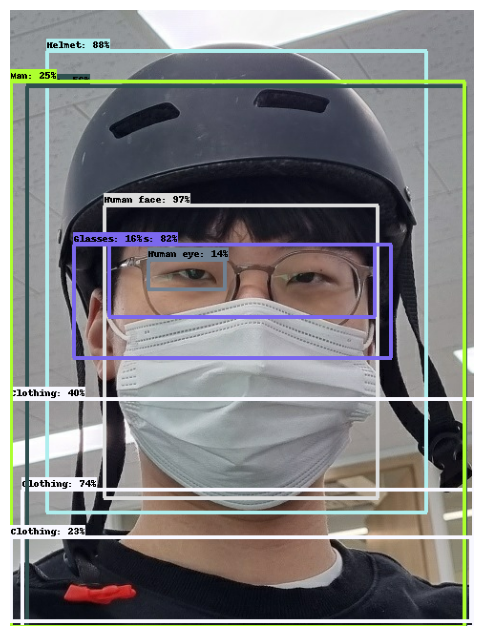

In [15]:
run_detector(detector, './hs.png')